In [1]:
import geopandas as gpd
import pandas as pd
import os
from tqdm import tqdm
import rioxarray as riox
import xarray as xr
import gc
import numpy as np

In [2]:
from src.hls_funcs.masks import shp2mask
from src.hls_funcs import fetch

In [40]:
def soiltexturalclass(sand, clay, silt=None):
    """Function that returns the USDA 
    soil textural class given 
    the percent sand and clay.
    
    Inputs = Percetnage of sand and clay
    """
    
    if silt is None:
        silt = 100 - sand - clay
    else:
        tot = sand + silt + clay
        sand = sand/tot * 100
        silt = silt/tot * 100
        clay = clay/tot * 100
    
    if sand + clay > 100 or sand < 0 or clay < 0:
        raise Exception('Inputs adds over 100% or are negative')

    elif silt + 1.5*clay < 15:
        textural_class = 'sand'

    elif silt + 1.5*clay >= 15 and silt + 2*clay < 30:
        textural_class = 'loamy sand'

    elif (clay >= 7 and clay < 20 and sand > 52 and silt + 2*clay >= 30) or (clay < 7 and silt < 50 and silt + 2*clay >= 30):
        textural_class = 'sandy loam'

    elif clay >= 7 and clay < 27 and silt >= 28 and silt < 50 and sand <= 52:
        textural_class = 'loam'

    elif (silt >= 50 and clay >= 12 and clay < 27) or (silt >= 50 and silt < 80 and clay < 12):
        textural_class = 'silt loam'

    elif silt >= 80 and clay < 12:
        textural_class = 'silt'

    elif clay >= 20 and clay < 35 and silt < 28 and sand > 45:
        textural_class = 'sandy clay loam'

    elif clay >= 27 and clay < 40 and sand > 20 and sand <= 45:
        textural_class = 'clay loam'

    elif clay >= 27 and clay < 40 and sand <= 20:
        textural_class = 'silty clay loam'

    elif clay >= 35 and sand > 45:
        textural_class = 'sandy clay'

    elif clay >= 40 and silt >= 40:
        textural_class = 'silty clay'

    elif clay >= 40 and sand <= 45 and silt < 40:
        textural_class = 'clay'

    else:
        textural_class = 'na'

    return textural_class

In [45]:
outDIR = '/mnt/d/TBNG/data/rasters/soil_products'
outDIR_shps = '/mnt/d/TBNG/data/vectors/soil_products'
if not os.path.exists(outDIR):
    os.mkdir(outDIR)

In [46]:
gdf_texture = gpd.read_file('/mnt/d/gen_data/vectors/SSURGO/Text.dbf')
gdf_texture['mukey'] = gdf_texture['mukey'].astype('int')

In [49]:
for idx, d in enumerate(tqdm(os.listdir('/mnt/d/TBNG/data/vectors/SSURGO/'))):
    gdf_shp = gpd.read_file(os.path.join('/mnt/d/TBNG/data/vectors/SSURGO/',
                                         d,
                                         'spatial/soilmu_a_' + d.lower() + '.shp'))
    gdf_shp = gdf_shp.to_crs('EPSG: 32613')
    gdf_shp['MUKEY'] = gdf_shp['MUKEY'].astype('int')

    gdf_shp = pd.merge(gdf_shp, gdf_texture.drop(columns='geometry'), how='inner', left_on='MUKEY', right_on='mukey')

    gdf_shp['texcl'] = gdf_shp.apply(lambda x: soiltexturalclass(x['AVG_SAND'], x['AVG_CLAY'], x['AVG_SILT']), axis=1)
    
    if idx == 0:
        gdf_out = gdf_shp
    else:
        gdf_out = pd.concat([gdf_out, gdf_shp])
    
gdf_out.to_file(os.path.join(outDIR_shps, 'TBNG_soiltexture_avg.shp'))

100%|█████████████████████████████████████████████████████████████████████████████████████| 6/6 [01:02<00:00, 10.39s/it]


In [4]:
for idx, d in enumerate(tqdm(os.listdir('/mnt/d/TBNG/data/vectors/SSURGO/'))):
    gdf_shp = gpd.read_file(os.path.join('/mnt/d/TBNG/data/vectors/SSURGO/',
                                         d,
                                         'spatial/soilmu_a_' + d.lower() + '.shp'))
    gdf_shp = gdf_shp.to_crs('EPSG: 32613')
    gdf_shp['MUKEY'] = gdf_shp['MUKEY'].astype('int')
    df_comp = pd.read_csv(os.path.join('/mnt/d/TBNG/data/vectors/SSURGO/', d, 'tabular/comp.txt'),
                          delimiter='|', header=None,
                          usecols=[107, 108], names=['mukey', 'cokey'])
    df_chorizon = pd.read_csv(os.path.join('/mnt/d/TBNG/data/vectors/SSURGO/', d, 'tabular/chorizon.txt'),
                              delimiter='|', header=None,
                          usecols=[169, 170], names=['cokey', 'chkey'])
    df_chtexgrp = pd.read_csv(os.path.join('/mnt/d/TBNG/data/vectors/SSURGO/', d, 'tabular/chtexgrp.txt'),
                              delimiter='|', header=None,
                          usecols=[4, 5], names=['chkey', 'chtgkey'])
    df_chtextur = pd.read_csv(os.path.join('/mnt/d/TBNG/data/vectors/SSURGO/', d, 'tabular/chtextur.txt'),
                              delimiter='|', header=None,
                             usecols=[0, 2, 3], names=['texcl', 'chtgkey', 'chtkey'])
    df_unified = pd.merge(
        pd.merge(
            pd.merge(
                df_comp, df_chorizon, how='inner', on='cokey'), 
            df_chtexgrp, how='inner', on='chkey'),
        df_chtextur, how='inner', on='chtgkey')
    gdf_shp = pd.merge(gdf_shp, df_unified, how='inner', left_on='MUKEY', right_on='mukey')
    if idx == 0:
        gdf_out = gdf_shp
    else:
        gdf_out = pd.concat([gdf_out, gdf_shp])

100%|█████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:51<00:00,  8.60s/it]


In [5]:
gdf_out.head()

,AREASYMBOL,SPATIALVER,MUSYM,MUKEY,geometry,mukey,cokey,chkey,chtgkey,texcl,chtkey
0,WY011,7,P438C,2745798,"POLYGON ((526502.949 4946432.307, 526505.212 4...",2745798,23179744,68709808,138434290,Silty clay,140798422
1,WY011,7,P438C,2745798,"POLYGON ((526502.949 4946432.307, 526505.212 4...",2745798,23179744,68709808,138434291,Clay,140798423
2,WY011,7,P438C,2745798,"POLYGON ((526502.949 4946432.307, 526505.212 4...",2745798,23179744,68709808,138434292,Clay loam,140798424
3,WY011,7,P438C,2745798,"POLYGON ((526502.949 4946432.307, 526505.212 4...",2745798,23179744,68709806,138434286,NaN,140798425
4,WY011,7,P438C,2745798,"POLYGON ((526502.949 4946432.307, 526505.212 4...",2745798,23179744,68709807,138434287,Silty clay,140798426


In [21]:
gdf_out[gdf_out['MUKEY'] == 349787].drop_duplicates()

,AREASYMBOL,SPATIALVER,MUSYM,MUKEY,geometry,mukey,cokey,chkey,chtgkey,texcl,chtkey
70042,WY605,8,102,349787,"POLYGON ((459721.548 4848626.707, 459699.337 4...",349787,23192883,68747293,138499466,Clay,140872398
70043,WY605,8,102,349787,"POLYGON ((459721.548 4848626.707, 459699.337 4...",349787,23192883,68747293,138499467,Clay loam,140872399
70044,WY605,8,102,349787,"POLYGON ((459721.548 4848626.707, 459699.337 4...",349787,23192883,68747294,138499468,Clay loam,140872692
70045,WY605,8,102,349787,"POLYGON ((459721.548 4848626.707, 459699.337 4...",349787,23192883,68747294,138499469,Loam,140872693
70046,WY605,8,102,349787,"POLYGON ((459721.548 4848626.707, 459699.337 4...",349787,23192883,68747292,138499465,Loam,140872244
...,...,...,...,...,...,...,...,...,...,...,...
82401,WY605,8,102,349787,"POLYGON ((478157.216 4878551.246, 478172.939 4...",349787,23192888,68747313,138499505,Clay,140872408
82402,WY605,8,102,349787,"POLYGON ((478157.216 4878551.246, 478172.939 4...",349787,23192888,68747314,138499506,Loam,140873700
82403,WY605,8,102,349787,"POLYGON ((478157.216 4878551.246, 478172.939 4...",349787,23192888,68747314,138499507,Clay loam,140873701
82404,WY605,8,102,349787,"POLYGON ((478157.216 4878551.246, 478172.939 4...",349787,23192888,68747312,138499503,Loam,140872701


In [6]:
texcl_dict_rev = {x:i for i, x in enumerate(gdf_out['texcl'].unique())}
texcl_dict = {i:x for i, x in enumerate(gdf_out['texcl'].unique())}
texcl_dict

{0: 'Silty clay',
 1: 'Clay',
 2: 'Clay loam',
 3: nan,
 4: 'Loam',
 5: 'Silty clay loam',
 6: 'Sandy loam',
 7: 'Loamy sand',
 8: 'Loamy fine sand',
 9: 'Fine sandy loam',
 10: 'Sandy clay loam',
 11: 'Very fine sandy loam',
 12: 'Silt loam',
 13: 'Fine sand',
 14: 'Loamy very fine sand',
 15: 'Coarse sandy loam',
 16: 'Sand',
 17: 'Loamy coarse sand',
 18: 'Coarse sand',
 19: 'Silt',
 20: 'Sandy clay'}

In [7]:
texcl_dict[3] = 'Unknown'

In [8]:
texcl_dict_simp = {'Silty clay': 'Clay',
                   'Clay': 'Clay',
                   'Clay loam': 'Clay loam',
                   'Unknown': 'Unknown',
                   'Loam': 'Loam',
                   'Silty clay loam': 'Clay loam',
                   'Sandy loam': 'Sandy loam',
                   'Loamy sand': 'Loamy sand',
                   'Loamy fine sand': 'Loamy sand',
                   'Fine sandy loam': 'Sandy loam',
                   'Sandy clay loam': 'Clay loam',
                   'Very fine sandy loam': 'Sandy loam',
                   'Silt loam': 'Silt loam',
                   'Fine sand': 'Sand',
                   'Loamy very fine sand': 'Loamy sand',
                   'Coarse sandy loam': 'Sandy loam',
                   'Sand': 'Sand',
                   'Loamy coarse sand': 'Loamy sand',
                   'Coarse sand': 'Sand',
                   'Silt': 'Silt',
                   'Sandy clay': 'Sandy clay'}

In [9]:
texcl_simp_list =list( np.unique([v for v in texcl_dict_simp.values()]))

In [10]:
texcl_dict_vsimp = {'Clay': 'Clayey',
                    'Clay loam': 'Loamy',
                    'Loam': 'Loamy',
                    'Loamy sand': 'Sandy',
                    'Sand': 'Sandy',
                    'Sandy clay': 'Clayey',
                    'Sandy loam': 'Loamy',
                    'Silt': 'Silty',
                    'Silt loam': 'Loamy',
                    'Unknown': 'Unknown'}

In [11]:
texcl_vsimp_list = list(np.unique([v for v in texcl_dict_vsimp.values()]))

In [17]:
texcl_vsimp_list

['Clayey', 'Loamy', 'Sandy', 'Silty', 'Unknown']

In [18]:
texcl_vsimp_list.index('Clayey')

0

In [16]:
for tilename in tqdm(gdf_out['AREASYMBOL'].unique(), 
                     total=len(gdf_out['AREASYMBOL'].unique()), position=0, leave=True):

    gdf_out_sub = gdf_out[gdf_out['AREASYMBOL'] == tilename]
    sub_bounds = gdf_out_sub.total_bounds

    # fetch the data
    hls_ds = fetch.get_hls(hls_data={'date_range': ['2022-05-01', '2022-05-10']},
                           bbox=sub_bounds, 
                           stack_chunks=(400, 400),
                           proj_epsg=gdf_out.crs.to_epsg(),
                           lim=10,
                           aws=False)['BLUE'].isel(time=1)

    gdf_info = gdf_out_sub[['texcl', 'geometry']].reset_index(drop=True).reset_index().rename(columns={'index': 'id'})
    print('creating final shapefile')
    texcl_mask_shp = [(row.geometry, texcl_dict_rev[row.texcl]) for _, row in tqdm(gdf_info.iterrows(), 
                                                                  total=len(gdf_info), position=0, leave=True)]
    del gdf_out_sub, gdf_info
    gc.collect()

    da_texture = shp2mask(texcl_mask_shp, hls_ds, hls_ds.rio.transform(), hls_ds.shape)

    da_texture_cl = xr.DataArray(
        data=np.array([texcl_dict[i] for i in da_texture.values.flatten()]).reshape(da_texture.shape),
        coords=da_texture.coords)

    da_texture_cl_simp = xr.DataArray(
        data=np.array([texcl_dict_simp[i] for i in da_texture_cl.values.flatten()]).reshape(da_texture_cl.shape),
        coords=da_texture_cl.coords)

    da_texture_cl_vsimp = xr.DataArray(
        data=np.array([texcl_dict_vsimp[i] for i in da_texture_cl_simp.values.flatten()]).reshape(da_texture_cl_simp.shape),
        coords=da_texture_cl_simp.coords)

    da_texture_cl_simp.values = np.array([texcl_simp_list.index(i) for i in da_texture_cl_simp.values.flatten()]).reshape(da_texture_cl_simp.shape)

    da_texture_cl_vsimp.values = np.array([texcl_vsimp_list.index(i) for i in da_texture_cl_vsimp.values.flatten()]).reshape(da_texture_cl_vsimp.shape)

    da_texture.rio.set_crs(32613).rio.to_raster(
        os.path.join(outDIR, tilename + '_texcl.tif'), dtype='uint16')
    
    da_texture_cl_simp.rio.set_crs(32613).rio.to_raster(
        os.path.join(outDIR, tilename + '_texcl_simp.tif'), dtype='uint16')

    da_texture_cl_vsimp.rio.set_crs(32613).rio.to_raster(
        os.path.join(outDIR, tilename + '_texcl_vsimp.tif'), dtype='uint16')
    
    del da_texture_cl, da_texture_cl_simp, da_texture_cl_vsimp, da_texture, hls_ds
    gc.collect()

  0%|                                                                                             | 0/5 [00:00<?, ?it/s]

creating final shapefile


 20%|█████████████████                                                                    | 1/5 [01:22<05:29, 82.49s/it]

creating final shapefile


 40%|██████████████████████████████████                                                   | 2/5 [02:06<03:00, 60.12s/it]

creating final shapefile


 60%|███████████████████████████████████████████████████                                  | 3/5 [03:02<01:56, 58.21s/it]

creating final shapefile


 80%|████████████████████████████████████████████████████████████████████                 | 4/5 [04:05<00:59, 59.80s/it]

creating final shapefile


100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [05:31<00:00, 66.36s/it]


In [15]:
da_texture.rio.set_crs(32613).rio.to_raster(
    os.path.join(outDIR, tilename + '_texcl.tif'), dtype='uint16')

da_texture_cl_simp.rio.set_crs(32613).rio.to_raster(
    os.path.join(outDIR, tilename + '_texcl_simp.tif'), dtype='uint16')

da_texture_cl_vsimp.rio.set_crs(32613).rio.to_raster(
    os.path.join(outDIR, tilename + '_texcl_vsimp.tif'), dtype='uint16')

In [ ]:
da_texture_cl_simp

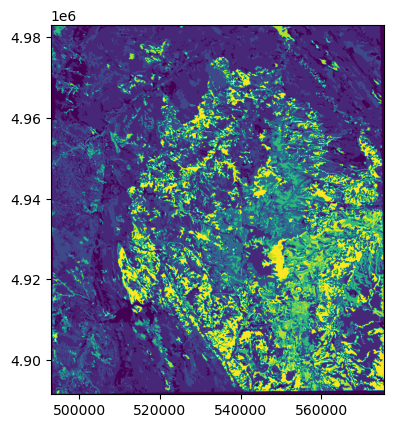

<AxesSubplot: >

In [73]:
show(da_texture_cl_simp.data, transform=da_texture_cl_simp.rio.transform())

In [34]:
from rasterio.plot import show
show(da_texture_cl.astype('int').data)

ValueError: invalid literal for int() with base 10: 'Silty clay'

In [6]:
gdf_out.to_file('/mnt/d/TBNG/data/vectors/soil_products/tb_soil_texture_unified.shp')

RuntimeError: GDAL Error: Failed to write shape object. The maximum file size of 4294964456 has been reached. The current record of size 17860 cannot be added. 
 
 Failed to write record: {'id': '171285', 'type': 'Feature', 'properties': {'AREASYMBOL': 'WY045', 'MUKEY': 2768032, 'MUSYM': 'P086D', 'SPATIALVER': 10, 'chkey': 68740977, 'chtgkey': 138488229, 'chtkey': 140862758, 'cokey': 23189958, 'mukey': 2768032, 'texcl': None}, 'geometry': {'type': 'Polygon', 'coordinates': (((-104.182721535535, 44.0684163425404), (-104.182642744474, 44.0684302138745), (-104.182484308335, 44.0685030183036), (-104.182339788515, 44.0685452564798), (-104.181693557122, 44.0686599071702), (-104.181597383323, 44.0686964563989), (-104.181478537977, 44.0687848167119), (-104.181336747007, 44.0688079812928), (-104.180935420922, 44.0689831099313), (-104.180592607362, 44.069070004908), (-104.179736338043, 44.0691319097469), (-104.17931450881, 44.0691786737946), (-104.178718400109, 44.0692920134023), (-104.178029713722, 44.0695343932358), (-104.177324667302, 44.0697453732214), (-104.176701104988, 44.07001703033), (-104.176551653636, 44.0701018749453), (-104.176115852856, 44.0705545725071), (-104.176073898324, 44.0706237766424), (-104.176019469492, 44.0707981720884), (-104.176036237282, 44.0709060586264), (-104.176346567903, 44.0714261043845), (-104.176420384312, 44.071621386643), (-104.176423293779, 44.0716977225474), (-104.176353130572, 44.0721485463701), (-104.176220626159, 44.0725411073704), (-104.17617264566, 44.0726124842135), (-104.175933143457, 44.0728370163136), (-104.175275163287, 44.0731467988998), (-104.174979061858, 44.0733190123201), (-104.174707534564, 44.0735491200989), (-104.174610858928, 44.0736964177234), (-104.174602945435, 44.073849937809), (-104.174667181113, 44.0739656967652), (-104.175260932686, 44.0744691506649), (-104.176022018231, 44.0753178453361), (-104.176055701629, 44.0754408918269), (-104.17603810872, 44.0760045969342), (-104.17605164852, 44.0760856782494), (-104.17616315347, 44.0763641537345), (-104.176339493433, 44.0765963168857), (-104.176444898541, 44.0766780270827), (-104.176689923001, 44.0768123287856), (-104.176947270927, 44.0768297442444), (-104.17702955808, 44.0768030581402), (-104.177110680984, 44.0767458373244), (-104.177276332461, 44.0764196399799), (-104.177329996655, 44.0763641147566), (-104.177398187247, 44.076324796066), (-104.17767209748, 44.0762709721586), (-104.178036720091, 44.0763438734974), (-104.178222464288, 44.0765079392146), (-104.178338863539, 44.0767852112171), (-104.178448772453, 44.0773842537058), (-104.17844479782, 44.0774556146024), (-104.178412268261, 44.077540441694), (-104.178150219136, 44.077442301671), (-104.177839562454, 44.0773894723005), (-104.177685829413, 44.0773971662192), (-104.177531885013, 44.0774552838928), (-104.177435979616, 44.0775359227818), (-104.1773860828, 44.0776227222765), (-104.17727787398, 44.078081302531), (-104.177185806883, 44.0782877315972), (-104.177019062988, 44.0784483611418), (-104.17678637904, 44.0785626513337), (-104.176589241054, 44.0786171336652), (-104.176257970222, 44.0786645945993), (-104.175863105219, 44.0786538677221), (-104.175661939888, 44.0786644877284), (-104.175565705151, 44.0786902336551), (-104.175337105869, 44.0787862650704), (-104.174765113912, 44.0788395818677), (-104.17457907833, 44.0789131799722), (-104.174457666353, 44.0789908902196), (-104.17431027766, 44.078999088551), (-104.173832752701, 44.0789493486687), (-104.17361234805, 44.078988158908), (-104.172780417744, 44.0793680783655), (-104.172193203824, 44.079702283452), (-104.171877418562, 44.0798261940322), (-104.17163701761, 44.0798869392789), (-104.171333713648, 44.0799056558022), (-104.17093141799, 44.0798854702342), (-104.17057534477, 44.0799776561682), (-104.170419303233, 44.0799557773679), (-104.16992047209, 44.0798335219045), (-104.16951415054, 44.0798738933491), (-104.169169239133, 44.0800797111747), (-104.168946966824, 44.0803328743408), (-104.168686152074, 44.0805479060629), (-104.168592450843, 44.0805842927292), (-104.168289162592, 44.0806345078442), (-104.168118611448, 44.0806801355057), (-104.168014751532, 44.0807261502813), (-104.167800399043, 44.0808780013788), (-104.16776396015, 44.0809513641363), (-104.167729495728, 44.0811038220678), (-104.167825462212, 44.0813265519293), (-104.168183678169, 44.081565512912), (-104.168516898887, 44.0816385788346), (-104.168613395187, 44.0816776361604), (-104.168771865981, 44.0818136922564), (-104.168868142272, 44.0819553852564), (-104.168901468164, 44.0821486718826), (-104.168819075659, 44.0823625998548), (-104.168646921394, 44.0825307536518), (-104.168356658058, 44.082720595725), (-104.168279004728, 44.0828172055954), (-104.168262924689, 44.0828821113876), (-104.168266258797, 44.0829098118228), (-104.1683252873, 44.0829718851626), (-104.168635679049, 44.0830850680394), (-104.168810014972, 44.0832066430757), (-104.168910510753, 44.0833624794421), (-104.168921439496, 44.0834428230941), (-104.168901980405, 44.0835214404851), (-104.168808634982, 44.0836757312825), (-104.168708297789, 44.0837719404235), (-104.168621306015, 44.0838223163711), (-104.168179702902, 44.0839458766663), (-104.1676989107, 44.0840259423874), (-104.167233672364, 44.084172561889), (-104.166912042068, 44.0843526326604), (-104.166549185529, 44.0846603724756), (-104.166496581307, 44.0847248299179), (-104.166442055726, 44.084856920703), (-104.166440387129, 44.0849893527863), (-104.166523452021, 44.0853452102543), (-104.166628111954, 44.0856088160658), (-104.166684197331, 44.0858763176709), (-104.166735882696, 44.0860027592296), (-104.166759312979, 44.086354193135), (-104.166810910282, 44.086511247101), (-104.166819958289, 44.0866700248484), (-104.166866708324, 44.0868912922005), (-104.166841580051, 44.0870377744172), (-104.166253269947, 44.0867679843148), (-104.165846096535, 44.0867075723763), (-104.165572271195, 44.086689348501), (-104.16522411496, 44.0866072917886), (-104.164941007765, 44.0864492077075), (-104.164462571654, 44.0860682134346), (-104.164289006504, 44.0859843928558), (-104.163652436107, 44.0859300148899), (-104.16279960826, 44.0859177701487), (-104.162697661765, 44.0858961477886), (-104.162583107995, 44.0858428953304), (-104.162470430605, 44.0857634214301), (-104.162356752348, 44.0856128936274), (-104.162343739811, 44.085556983283), (-104.162376913565, 44.085498226248), (-104.162905574174, 44.0851991829047), (-104.163353526463, 44.0850446428853), (-104.163487701221, 44.0849787593132), (-104.163590287461, 44.0848698130659), (-104.1636021452, 44.0847070468166), (-104.163572366959, 44.0846476691862), (-104.163521410004, 44.084600399463), (-104.163305887454, 44.0844813563893), (-104.163096377818, 44.0844645646147), (-104.162576135028, 44.0844885304017), (-104.162433411179, 44.0844415154198), (-104.162239607321, 44.0843148307738), (-104.162266975446, 44.0840718919809), (-104.162389781373, 44.0838905853524), (-104.162607123339, 44.083752962247), (-104.163056183202, 44.0836181591128), (-104.16370440886, 44.0835709980896), (-104.164254141827, 44.0836145243374), (-104.16496146509, 44.0837554552349), (-104.165331823194, 44.0837713282249), (-104.165607343749, 44.083720132158), (-104.165774851622, 44.0836386878488), (-104.166049782631, 44.0834362942944), (-104.166395987505, 44.0832619119237), (-104.166565433257, 44.0831443392373), (-104.166745448333, 44.0829892065006), (-104.166960505444, 44.082749094446), (-104.167003509874, 44.0826780274337), (-104.167001858727, 44.0826016126929), (-104.166965149951, 44.082526459863), (-104.166743844479, 44.0823384645788), (-104.166591912514, 44.0822776191362), (-104.166197762043, 44.0822416127466), (-104.16603253053, 44.0821851876331), (-104.165829474825, 44.0820338738929), (-104.165651861333, 44.0818431830189), (-104.165477857088, 44.0817242848497), (-104.165392142684, 44.0817016641717), (-104.165086678749, 44.081702495235), (-104.164982301438, 44.0817233340421), (-104.164716553316, 44.0818243372814), (-104.164618309242, 44.0818438974468), (-104.164525189338, 44.0818433373952), (-104.164442897224, 44.0818178045355), (-104.164369044065, 44.0817683463673), (-104.164094846859, 44.0814332766633), (-104.163896641305, 44.081269959105), (-104.163820011963, 44.0812287736066), (-104.163402864057, 44.0811896762913), (-104.163291278673, 44.0812028564117), (-104.163119086209, 44.0812557801013), (-104.162827535139, 44.0811945355839), (-104.162310036277, 44.0811679220084), (-104.161974543069, 44.0810967815694), (-104.161543840456, 44.0810495121138), (-104.161093564466, 44.0809440352385), (-104.160865368343, 44.0809076880967), (-104.16076454568, 44.0809057998163), (-104.160491339496, 44.0809343387383), (-104.160294545056, 44.0810022775244), (-104.160214717455, 44.0810495054852), (-104.159921675044, 44.0812791069694), (-104.159737777577, 44.0815379899804), (-104.1597452029, 44.081767080202), (-104.159821684597, 44.0820162204632), (-104.159930348855, 44.0822192685402), (-104.160074990901, 44.0823345817551), (-104.160308175065, 44.0824228342192), (-104.160406867012, 44.0824383571282), (-104.160721179323, 44.0824378919468), (-104.161268727156, 44.0824842650073), (-104.161634002261, 44.0827507140288), (-104.161670705269, 44.082825868366), (-104.16167000279, 44.0829141303806), (-104.161600209553, 44.0831911898144), (-104.161394803749, 44.0835117146047), (-104.161279261414, 44.0838789122234), (-104.161036388066, 44.084170238966), (-104.16099449229, 44.0842610397342), (-104.160732143473, 44.0842754065311), (-104.16034570495, 44.0842722139815), (-104.159995093058, 44.0843055210055), (-104.159766784887, 44.0843519956459), (-104.159318792472, 44.0843597943282), (-104.1590473163, 44.0843819216484), (-104.15866492337, 44.0844855976893), (-104.158202214746, 44.0846743374229), (-104.157975111613, 44.0847099323333), (-104.157121884937, 44.0847255826301), (-104.156950024557, 44.0846767558628), (-104.156811490518, 44.0845808666969), (-104.156644511909, 44.0843634034205), (-104.156614377137, 44.0842905437715), (-104.156591030626, 44.0840858384094), (-104.156606370282, 44.0840146788607), (-104.156662002569, 44.0839230337987), (-104.156761189915, 44.0838485101508), (-104.156959552172, 44.0837516743354), (-104.157638779083, 44.0834811872155), (-104.157954085026, 44.0833843474528), (-104.158128512799, 44.0832871838585), (-104.158486314855, 44.0830103875974), (-104.158667606704, 44.0828029773772), (-104.15871478944, 44.0826515393982), (-104.15869628177, 44.0824348341505), (-104.158558789171, 44.0822011545238), (-104.15824859883, 44.0819430070969), (-104.158168938628, 44.0818975042351), (-104.157992199193, 44.0818498802489), (-104.157848476582, 44.0817840187412), (-104.157635965646, 44.0816584814582), (-104.15743374877, 44.0815035038663), (-104.157370838776, 44.0814299632513), (-104.157141006062, 44.0810138327061), (-104.156966923189, 44.0808418186318), (-104.156717801514, 44.0806627241822), (-104.156376422311, 44.0804902121039), (-104.156278512244, 44.0804602354128), (-104.155988729378, 44.0804240727487), (-104.155703751395, 44.0803651090043), (-104.155222875068, 44.0803083072483), (-104.155126562838, 44.0802602277413), (-104.154964458962, 44.0801459857511), (-104.154861986656, 44.0799524562219), (-104.154781378382, 44.0795118312427), (-104.154644375063, 44.0792088061956), (-104.154569245033, 44.0787300370402), (-104.154430513184, 44.0783812098023), (-104.154393660322, 44.0781791390491), (-104.154267491621, 44.077934859104), (-104.154044357905, 44.0776893487708), (-104.154022012711, 44.0776394147383), (-104.154126186353, 44.0775645865484), (-104.154318977686, 44.0774843011894), (-104.155436343276, 44.0774073869986), (-104.156106723085, 44.077178860566), (-104.156272722833, 44.0770849194269), (-104.156665311373, 44.0767420746986), (-104.156971685567, 44.0765188620791), (-104.157123857483, 44.076372661263), (-104.157181186646, 44.0762638090647), (-104.15718005754, 44.0762125686117), (-104.15713202266, 44.0761372124372), (-104.157011167905, 44.0760627414294), (-104.15691825637, 44.076032457927), (-104.156678067966, 44.0760112466268), (-104.156164946691, 44.0760311513543), (-104.155737339848, 44.0759674719379), (-104.15543666478, 44.0758509648399), (-104.155083113393, 44.0755873848164), (-104.1549850631, 44.0754619982787), (-104.154915773083, 44.0752934325588), (-104.154883094193, 44.0750947068084), (-104.154894205973, 44.0748104684607), (-104.154961226796, 44.0746776163666), (-104.155249063541, 44.0743943384627), (-104.155379922688, 44.0741963427807), (-104.155445478377, 44.0739780645711), (-104.155422675766, 44.0737778309425), (-104.155369464213, 44.0736802893165), (-104.155302752452, 44.0736168854564), (-104.155211401582, 44.0735576996177), (-104.155118386904, 44.0735265214481), (-104.154874544246, 44.0735271366862), (-104.15444323617, 44.073610409889), (-104.154276533092, 44.0734577456001), (-104.154189908378, 44.0732704442331), (-104.154218253084, 44.0730877649633), (-104.154344683658, 44.0729575561232), (-104.15458385442, 44.0728762143725), (-104.154953493235, 44.0728552495961), (-104.155135373814, 44.0728935568907), (-104.155855759758, 44.0731129356331), (-104.156002896689, 44.0731236762972), (-104.15612006626, 44.0731047567963), (-104.156466231853, 44.0729826144305), (-104.156658334601, 44.0728339549846), (-104.156697491989, 44.0727622297905), (-104.156714129559, 44.0726495839268), (-104.156642757302, 44.0724532430012), (-104.156570194329, 44.0723829990322), (-104.156444247308, 44.0723079420301), (-104.156228360639, 44.0722168211362), (-104.155963667144, 44.0721485099928), (-104.155701858258, 44.0719891038229), (-104.155471852908, 44.0715711910112), (-104.155339920354, 44.0710905273466), (-104.155222779771, 44.0709213100631), (-104.155117154044, 44.070826997348), (-104.155007556568, 44.0707833383997), (-104.15487753474, 44.0707580404258), (-104.154646638468, 44.0707407553726), (-104.154459825309, 44.0707450594141), (-104.154290296656, 44.0707257946301), (-104.153901212812, 44.0706057298791), (-104.153136674175, 44.0701964278085), (-104.152478261779, 44.0698751046613), (-104.151713795482, 44.069424384241), (-104.151558014762, 44.0693520606332), (-104.151412122842, 44.0693097334646), (-104.151308154212, 44.0692396207546), (-104.151023768321, 44.0691014010359), (-104.150778449233, 44.0689220690897), (-104.150682240555, 44.0688118713973), (-104.150501304025, 44.0684881513458), (-104.150443941943, 44.0684187697927), (-104.149960778532, 44.0679966334478), (-104.149335546084, 44.0675220300781), (-104.149244215451, 44.0673791261401), (-104.149108087104, 44.0669887369585), (-104.149109903296, 44.066773488732), (-104.149129273188, 44.0666939832838), (-104.149282125802, 44.06636502124), (-104.149553197946, 44.0659945766524), (-104.149591235669, 44.065871615042), (-104.149599984046, 44.0657036484722), (-104.149547640899, 44.0654980354505), (-104.149437893679, 44.0652959559116), (-104.149174338309, 44.0650169292157), (-104.149073525078, 44.0648683087139), (-104.149009813521, 44.0645679799578), (-104.149008025691, 44.0644483702886), (-104.149123704754, 44.0639668722861), (-104.149341233814, 44.0635484166381), (-104.149447810304, 44.0632529093753), (-104.149559116938, 44.0630282225059), (-104.149634772573, 44.0626112987131), (-104.149636656573, 44.062187214452), (-104.149819112275, 44.0618222261627), (-104.15009754824, 44.0617645792628), (-104.15021192186, 44.0617539377156), (-104.150796398359, 44.0617638625003), (-104.150888711608, 44.0617788824425), (-104.150953719004, 44.0618072853555), (-104.151062464432, 44.0619068072945), (-104.15110528822, 44.0620121881647), (-104.151082579587, 44.0621162028868), (-104.151026715037, 44.0622267596785), (-104.150813756261, 44.0625261172224), (-104.150618983591, 44.0629350729162), (-104.150644021509, 44.0631540674875), (-104.150679346638, 44.0632284052499), (-104.15089599964, 44.0633680921422), (-104.150968388573, 44.0633951406343), (-104.151085447184, 44.0634068368545), (-104.151412635447, 44.063367789364), (-104.151899801854, 44.063132560089), (-104.152236361484, 44.0628994015982), (-104.152462389136, 44.0628449768496), (-104.152672246425, 44.0628338544273), (-104.152919699621, 44.0628636235954), (-104.153054038432, 44.0629354640029), (-104.153185437812, 44.0630560933672), (-104.153390713624, 44.0633522029432), (-104.153473219499, 44.0634425377244), (-104.153578254787, 44.0635215833433), (-104.153477924123, 44.0637014912436), (-104.153459378744, 44.0637773458452), (-104.153464861883, 44.064021849173), (-104.153498473291, 44.0640818896497), (-104.153670868791, 44.0641774904674), (-104.15411255495, 44.0643276179902), (-104.15449712104, 44.0645568751829), (-104.154799837804, 44.0648163772747), (-104.15484592986, 44.0648756488674), (-104.154857563634, 44.0649829507376), (-104.154832269986, 44.0650340171404), (-104.154782903689, 44.0650730639571), (-104.154710712641, 44.0651000142954), (-104.154626391341, 44.0651097086476), (-104.154388912527, 44.065079327653), (-104.15413502429, 44.0649437388033), (-104.15394269978, 44.0648601674978), (-104.153552831502, 44.0647437541325), (-104.153168408743, 44.0647773297585), (-104.152725800502, 44.0649126037755), (-104.152630422681, 44.0649139761741), (-104.152460562476, 44.0648290195468), (-104.15211482176, 44.0645775627197), (-104.151977996991, 44.0645373793314), (-104.151857125044, 44.0645358201938), (-104.151637612987, 44.0645817411961), (-104.151383138943, 44.0647657370936), (-104.151171874357, 44.0651316031775), (-104.151152876069, 44.0653398076121), (-104.151239799821, 44.0656135030778), (-104.151376697253, 44.0658427149317), (-104.151437050778, 44.0659056104111), (-104.151803271482, 44.0661810132605), (-104.152229739446, 44.0666021314566), (-104.15247141169, 44.0669500131972), (-104.152604529467, 44.0672523701662), (-104.152890046712, 44.0675570450232), (-104.153136507078, 44.0677354021893), (-104.153237470034, 44.0677804939147), (-104.153405433852, 44.06782866087), (-104.153669194904, 44.0679312387693), (-104.153970691726, 44.0679711816415), (-104.154481724841, 44.0683006723271), (-104.154604696715, 44.0683615106955), (-104.15476933503, 44.0683819759917), (-104.155371058995, 44.0683989234589), (-104.156128132237, 44.0682334677364), (-104.156996462898, 44.0677803030587), (-104.157103772852, 44.0677421862072), (-104.157334389567, 44.0677153756458), (-104.157619797512, 44.0677364979948), (-104.157769755963, 44.0677812681666), (-104.158021625484, 44.0679835882625), (-104.158071992425, 44.0680993062059), (-104.158130096088, 44.0683630742381), (-104.158238703494, 44.0685031086974), (-104.158293455228, 44.0685402423654), (-104.158394018949, 44.0685610507218), (-104.158665509221, 44.0684768094247), (-104.158845390712, 44.0684567232876), (-104.158942962418, 44.0684840167441), (-104.159124358154, 44.0686438696312), (-104.159090059741, 44.068871024207), (-104.159117331213, 44.0689305548094), (-104.159169950993, 44.0689813220418), (-104.15936433442, 44.0690818638101), (-104.15957895174, 44.069141551138), (-104.15975725485, 44.0691710701848), (-104.159886150662, 44.0692288385736), (-104.159771165072, 44.06946456703), (-104.159730183085, 44.069657027663), (-104.159720476749, 44.0697854494332), (-104.159761903188, 44.0699836335418), (-104.159763194751, 44.0702139966578), (-104.159687887344, 44.0704346777629), (-104.159669302286, 44.0706356602912), (-104.159701178359, 44.0707021086327), (-104.159797925702, 44.0707852630216), (-104.160059227671, 44.0709194875621), (-104.160151943987, 44.0709272760327), (-104.160268075465, 44.0709102169626), (-104.160569278017, 44.070759328474), (-104.160694055562, 44.0706364163965), (-104.160864968952, 44.0703639331633), (-104.161016515359, 44.0702231678523), (-104.161092478271, 44.0701752776399), (-104.161371443167, 44.0700590641295), (-104.161988960114, 44.0699039771802), (-104.162146033589, 44.069903296043), (-104.162376838386, 44.0699511793388), (-104.162940613835, 44.0701855734253), (-104.163043611501, 44.070216130374), (-104.163776566582, 44.0702159484464), (-104.163857960532, 44.070255038192), (-104.163978615172, 44.0703592199142), (-104.164004750994, 44.0704197201809), (-104.164001687191, 44.0704883220839), (-104.163915836556, 44.0706421437784), (-104.163634041869, 44.0708602567168), (-104.163403427533, 44.070970793668), (-104.162300681537, 44.0710324770504), (-104.161922409541, 44.0710233893496), (-104.161251499215, 44.0710377395902), (-104.161153980535, 44.0710527521151), (-104.161031410381, 44.0710999144182), (-104.160865918985, 44.0712397390309), (-104.160822476814, 44.0713594386603), (-104.1608278722, 44.0715193363926), (-104.160887965868, 44.0716740625277), (-104.160963177267, 44.0717558432495), (-104.161215186954, 44.0719068419553), (-104.161462412355, 44.071976219577), (-104.161695819066, 44.072077054417), (-104.16211478055, 44.0724139982237), (-104.162376325178, 44.0725815107548), (-104.162708670101, 44.0727104516334), (-104.162997820443, 44.0727520373144), (-104.163449958455, 44.0727061587384), (-104.163949832595, 44.0725763195929), (-104.164235699112, 44.0725487915836), (-104.164539157356, 44.0726047946674), (-104.164929018179, 44.0727832940797), (-104.165265464615, 44.0728417623015), (-104.165509949721, 44.0728464892576), (-104.165793040149, 44.0728272306987), (-104.166189103806, 44.07275419485), (-104.166392660483, 44.0727740468642), (-104.166333759675, 44.0728487935854), (-104.165763495454, 44.0732818417656), (-104.165630906269, 44.0734547510169), (-104.165622636749, 44.0735218741371), (-104.165640725854, 44.0735990740584), (-104.165678956934, 44.0736660300652), (-104.165877485673, 44.073863528267), (-104.165927818505, 44.0740728663591), (-104.165905432477, 44.0741480616043), (-104.165834306297, 44.0742361646561), (-104.165585799513, 44.0743757146312), (-104.165571423431, 44.0746115479921), (-104.165584908512, 44.074681830584), (-104.165628950511, 44.0747448277142), (-104.165695523509, 44.0747965334037), (-104.16578023825, 44.0748318172186), (-104.165879350466, 44.0748509100285), (-104.166661483796, 44.0748305789663), (-104.166934420556, 44.0748731569401), (-104.167027377164, 44.0749142329352), (-104.167151919772, 44.0749983697363), (-104.16737565262, 44.0752276188738), (-104.167483529894, 44.07546581444), (-104.167545002481, 44.0758617039469), (-104.167529257942, 44.076065216402), (-104.167409821231, 44.0764623630879), (-104.167386023038, 44.0767347865261), (-104.167402586552, 44.0768201826345), (-104.167526607408, 44.0770357788843), (-104.167610807558, 44.0770980992255), (-104.167789281389, 44.0771915121125), (-104.167886024979, 44.0772953673596), (-104.167921649824, 44.0774660056745), (-104.167892876895, 44.0778224541027), (-104.167964613208, 44.0779692606318), (-104.168034655274, 44.0780288534843), (-104.168167361682, 44.0780971835066), (-104.168604242742, 44.0782376687821), (-104.16867684701, 44.0782872012464), (-104.168724853725, 44.0783517539161), (-104.16874462598, 44.078432451368), (-104.168723379467, 44.078558888319), (-104.168590999764, 44.0787858005914), (-104.168540507666, 44.0789095407155), (-104.168562102451, 44.0791098511052), (-104.168590289165, 44.0791873290673), (-104.168652413895, 44.0792438094859), (-104.168803823057, 44.07933168987), (-104.169010799455, 44.0793693322438), (-104.169103485781, 44.079366314924), (-104.169358800038, 44.079314556407), (-104.169701058494, 44.0791494103925), (-104.169779757041, 44.0791346528942), (-104.169876250514, 44.0791737091096), (-104.170130631323, 44.0793335516316), (-104.17046588713, 44.0794235898818), (-104.170884643074, 44.0794238569498), (-104.171150608813, 44.0793561343907), (-104.171489011086, 44.0791903212576), (-104.171677633921, 44.0790337503292), (-104.171713185137, 44.0789739441148), (-104.171723020231, 44.0789094235284), (-104.171680476642, 44.0788067264722), (-104.17162355755, 44.0787517265288), (-104.171482281029, 44.0787271376391), (-104.170354517075, 44.0788327343875), (-104.170270160411, 44.0788109335295), (-104.170187418991, 44.0787503247618), (-104.170201066417, 44.0786234560385), (-104.1703383239, 44.0784475517587), (-104.170582618334, 44.0782938489571), (-104.171254268837, 44.07805526253), (-104.171723201512, 44.0778561885608), (-104.171877001555, 44.0777341733378), (-104.171895271728, 44.077697938402), (-104.171883393397, 44.077641059288), (-104.171786707445, 44.077579511843), (-104.171674247677, 44.0775540451816), (-104.170736652287, 44.0774948782106), (-104.170402954359, 44.0774281503256), (-104.170015396791, 44.0772900291778), (-104.169718458089, 44.0771526174144), (-104.169066898477, 44.0767328200785), (-104.16844091286, 44.0759090602695), (-104.168189295518, 44.0755212997222), (-104.168106976988, 44.0753283374203), (-104.168040359409, 44.0749210634262), (-104.167960169884, 44.074766677816), (-104.167645138896, 44.0744683464682), (-104.167151706741, 44.0741189062721), (-104.166991452387, 44.0739469544331), (-104.166897219353, 44.0737385239616), (-104.166886928995, 44.0735276166149), (-104.166917769717, 44.0734600013456), (-104.167037997708, 44.0733724698264), (-104.167213803796, 44.0733184173834), (-104.167348205179, 44.0733173286589), (-104.167451424617, 44.073349669468), (-104.167691853707, 44.0735400796429), (-104.167805565916, 44.0737013988463), (-104.167913315261, 44.073907194694), (-104.168038241623, 44.0740363158044), (-104.168289499947, 44.0742017524911), (-104.16843691842, 44.0742565711739), (-104.168539452112, 44.0742727503549), (-104.168637188863, 44.0742595194027), (-104.168726211738, 44.0742261217819), (-104.168803851936, 44.0741817239705), (-104.168888745377, 44.0741035719208), (-104.168937489985, 44.0739862416533), (-104.16899694192, 44.0736026974612), (-104.169084310495, 44.0734928862972), (-104.169162294745, 44.0734304634391), (-104.169207677148, 44.0734105600792), (-104.169289015366, 44.0734073421228), (-104.169405984567, 44.0734703394829), (-104.169476130818, 44.0735308245924), (-104.169572695064, 44.0737481115968), (-104.169527821537, 44.0739498203457), (-104.169320760145, 44.0742560548289), (-104.169258952696, 44.0744110987267), (-104.16927084371, 44.0746039043116), (-104.169312027712, 44.0746535740043), (-104.169405888462, 44.0747125962609), (-104.169570609446, 44.0747753481794), (-104.169803114305, 44.0748267162047), (-104.170567107048, 44.074770573773), (-104.171291137689, 44.0747898079389), (-104.17172561585, 44.0748791188496), (-104.172379734612, 44.0750799983391), (-104.172573745836, 44.0751040313896), (-104.172722309565, 44.0750534532633), (-104.172752047812, 44.0749976065866), (-104.172720587371, 44.0749347349982), (-104.172508586755, 44.0747821857793), (-104.172129561277, 44.0746417452127), (-104.171401101498, 44.0744499536761), (-104.170872270935, 44.0742557417989), (-104.170619090627, 44.0741057312905), (-104.170552966889, 44.0740368967593), (-104.170546512818, 44.0739832840625), (-104.170585678271, 44.0738908490545), (-104.170649782663, 44.0738175793268), (-104.170724042474, 44.0737868916506), (-104.170987403566, 44.0737499357496), (-104.171440510363, 44.0737642824062), (-104.171838960837, 44.0738468139204), (-104.172418207967, 44.0739271874021), (-104.172657598188, 44.074035737121), (-104.172978436715, 44.0742463811348), (-104.173121384182, 44.074378886761), (-104.173334677747, 44.074646578868), (-104.173845468772, 44.0750354354829), (-104.174171221332, 44.0752241696961), (-104.174282645345, 44.0752514982619), (-104.174441840084, 44.0752578738712), (-104.174517519688, 44.0752180944469), (-104.174683272162, 44.0750701327778), (-104.174748963105, 44.0749265481092), (-104.174742503779, 44.0748207247645), (-104.174688617973, 44.0747178294284), (-104.174479278282, 44.0744516953945), (-104.174124283764, 44.0742080558934), (-104.173206482629, 44.0738848335602), (-104.17257544049, 44.0737293443945), (-104.172071896248, 44.0734318563201), (-104.171803739458, 44.0733349832405), (-104.17159628489, 44.0733036774909), (-104.171418847545, 44.0733128275205), (-104.171271836385, 44.0733345025535), (-104.171074364516, 44.0734070010399), (-104.170936261694, 44.0734191241269), (-104.170832868154, 44.0733957984753), (-104.17070911969, 44.073328719736), (-104.170659199163, 44.0732795897042), (-104.170639210999, 44.0731971062685), (-104.1706952545, 44.0727435575245), (-104.17063486023, 44.0724925333567), (-104.170650205884, 44.0723484578104), (-104.170685582153, 44.0722976650899), (-104.170817099084, 44.0722517417376), (-104.17094340755, 44.0722565497317), (-104.171392499454, 44.0724673829735), (-104.171629322714, 44.0725337837335), (-104.172030305479, 44.0725747494228), (-104.172246106957, 44.0725605300796), (-104.172377171486, 44.0725317364936), (-104.172479057843, 44.0724903408124), (-104.172577070763, 44.0724167775971), (-104.172606635874, 44.0723699436786), (-104.172610272128, 44.0723166085407), (-104.172550258828, 44.0721627810585), (-104.172345346423, 44.0718288592143), (-104.172332672588, 44.071754926516), (-104.172347670238, 44.0716810862578), (-104.172429027632, 44.0716049504953), (-104.172484908431, 44.0716096030012), (-104.172608655519, 44.0716766798582), (-104.172743161827, 44.0717809000898), (-104.172974003795, 44.072016901491), (-104.17313198662, 44.0720863656478), (-104.173206372952, 44.0720880752186), (-104.173309613759, 44.0720474954375), (-104.173546367375, 44.0718105359193), (-104.173713577956, 44.0717164969224), (-104.173918746619, 44.071697529993), (-104.174183433997, 44.0717343002976), (-104.174516479474, 44.0716705303601), (-104.174600203763, 44.0716662615224), (-104.174639904035, 44.0716827142822), (-104.17470049948, 44.0717473869777), (-104.174800244211, 44.0720535919964), (-104.174996710531, 44.0723277201776), (-104.175089176011, 44.0724273326523), (-104.175230378865, 44.0725140338941), (-104.175319872553, 44.0725472161577), (-104.175515556142, 44.0725747418852), (-104.175618560535, 44.0725530786937), (-104.17578572649, 44.0724482374314), (-104.175812019468, 44.0724160076504), (-104.17588989538, 44.0720709295089), (-104.175779795152, 44.0717518616809), (-104.175578007417, 44.0713709417863), (-104.175403654919, 44.0709568216687), (-104.175350819846, 44.070726937141), (-104.175344094238, 44.0704518972051), (-104.175371673464, 44.070325969456), (-104.175579623266, 44.0700691805039), (-104.175670046616, 44.0698178480322), (-104.175754452628, 44.0697253186689), (-104.175884195469, 44.06965429454), (-104.176193622396, 44.0695406681576), (-104.176646379337, 44.0695523163274), (-104.176914302232, 44.0694907611901), (-104.177356493774, 44.0692060000605), (-104.177515339725, 44.0690530608004), (-104.177633755992, 44.0689089197168), (-104.177806543418, 44.0687569193893), (-104.177888517324, 44.0687068472411), (-104.1781296663, 44.0686109360303), (-104.178332328468, 44.0685921165615), (-104.178683892805, 44.0686613182294), (-104.178851636924, 44.0686761612246), (-104.178941768261, 44.0686624918434), (-104.179303858856, 44.0685582070852), (-104.18055867192, 44.0685067876685), (-104.180962226641, 44.068444045153), (-104.181069353241, 44.0684149212536), (-104.18180424705, 44.0681075568566), (-104.182179934727, 44.0678971024424), (-104.18225437218, 44.0678366909933), (-104.182451298703, 44.0676138783918), (-104.182520457578, 44.0675096841548), (-104.182542005998, 44.067438138309), (-104.182477011913, 44.0671910047396), (-104.182339602325, 44.0669897549524), (-104.182234825298, 44.0668819074601), (-104.182069807168, 44.0667957863933), (-104.181631426588, 44.0666842497978), (-104.181370566648, 44.0665122324224), (-104.181316911571, 44.0663904232508), (-104.181253035702, 44.0659334795381), (-104.181186541625, 44.0658511714678), (-104.181103096813, 44.0657951157695), (-104.180995815588, 44.0657603368206), (-104.180801675963, 44.0657246236254), (-104.180545477613, 44.0656225309811), (-104.180199476171, 44.0655367886414), (-104.179980297173, 44.0655332273706), (-104.179690982376, 44.0655736066171), (-104.179481957602, 44.0655604154162), (-104.178795434766, 44.0652778646535), (-104.178406235866, 44.0652091892672), (-104.17802311458, 44.0652535591916), (-104.177662961481, 44.0654468382126), (-104.177477846755, 44.0655068814208), (-104.177252559971, 44.0655360991399), (-104.177023740973, 44.0655151249426), (-104.176913152674, 44.0655363578299), (-104.176813775219, 44.0655776022079), (-104.176662507301, 44.0656994660968), (-104.176544269374, 44.0658868029161), (-104.176476391398, 44.0659495061719), (-104.175758606402, 44.0663467007099), (-104.175591091491, 44.0664902706065), (-104.175326719285, 44.066810854085), (-104.175223015894, 44.0668892714434), (-104.175103712153, 44.0669425469443), (-104.174827466096, 44.0668722870334), (-104.17459336873, 44.0667553157455), (-104.174072059428, 44.066737992265), (-104.173733096509, 44.0666689017544), (-104.173702543046, 44.0666239790572), (-104.173629883209, 44.0665843563416), (-104.173337051236, 44.0665016149282), (-104.173173981916, 44.0664315663944), (-104.173004348472, 44.0661503827496), (-104.172944166708, 44.0659011499412), (-104.173377124743, 44.0658321143387), (-104.173766598312, 44.0657360562669), (-104.17402060867, 44.0656321573972), (-104.174613200992, 44.0653228181097), (-104.174672237205, 44.0652597617114), (-104.17467700993, 44.0651532469187), (-104.174610715441, 44.0649890084249), (-104.174478240014, 44.0648180541864), (-104.174279886075, 44.064663769768), (-104.174090184294, 44.0645917664888), (-104.17369619558, 44.0644936680898), (-104.172718996293, 44.0643442554513), (-104.171993872713, 44.064074857507), (-104.170906444517, 44.0637197971935), (-104.170575870843, 44.0635844704076), (-104.170443427502, 44.0634972266621), (-104.170025404907, 44.0631575574592), (-104.169677568588, 44.0627847511676), (-104.169323718795, 44.0622574878617), (-104.16928835369, 44.0621516508251), (-104.16934494124, 44.0620473410394), (-104.169419361293, 44.0620076425538), (-104.169524007247, 44.062010186711), (-104.169774453614, 44.0620856481736), (-104.170040796353, 44.0622618464424), (-104.170326157152, 44.062512484256), (-104.170871458243, 44.0628442966763), (-104.171680038461, 44.0634416086799), (-104.171886150204, 44.0635351061148), (-104.172399280422, 44.0636726634435), (-104.172917383319, 44.0638828254672), (-104.175140445633, 44.0644918119031), (-104.175385957005, 44.0645261610112), (-104.175750468021, 44.0645360578932), (-104.176083456431, 44.0644929900987), (-104.176267257784, 44.0644429318442), (-104.176373882508, 44.0643679340071), (-104.176522326117, 44.0641913346643), (-104.176527119337, 44.0641163245264), (-104.176433089129, 44.063961901534), (-104.176242412356, 44.0637774404722), (-104.175961221733, 44.0635616621235), (-104.175409822512, 44.0632212431567), (-104.174512249051, 44.0626159447389), (-104.173672990663, 44.0617639974335), (-104.17344611679, 44.0614458441995), (-104.173362851702, 44.0611197250567), (-104.17335990373, 44.0610848007384), (-104.173403274924, 44.0610065094827), (-104.173475088256, 44.06096606936), (-104.173569061492, 44.0609530662379), (-104.174014684643, 44.0610416738736), (-104.174303559264, 44.0612065706784), (-104.174850489194, 44.061708396909), (-104.175198391837, 44.0620919881535), (-104.17577166825, 44.0625723817265), (-104.176296428723, 44.0629108430493), (-104.177207285282, 44.0636575373322), (-104.177438214953, 44.0637900014677), (-104.17785295267, 44.063976824117), (-104.178371128013, 44.0643021836599), (-104.178585942635, 44.0643843319058), (-104.179136241161, 44.0646527941695), (-104.180166457486, 44.0650437324865), (-104.180563771621, 44.0651380063814), (-104.181106398771, 44.0652070967125), (-104.181904441966, 44.0654656408502), (-104.182560520558, 44.0656519387618), (-104.182806145357, 44.0658122926174), (-104.183068998186, 44.0660633995404), (-104.183354755767, 44.0662437766456), (-104.183852685288, 44.0664425447248), (-104.184321960799, 44.0666538846607), (-104.184816601102, 44.0668357495224), (-104.185045230988, 44.0669593431837), (-104.185154061968, 44.0670903428686), (-104.185148631556, 44.0671599926291), (-104.185021534123, 44.0672632693818), (-104.18487099441, 44.0673076829943), (-104.184780605559, 44.0673087699166), (-104.184672009401, 44.0672839768649), (-104.184273661999, 44.0670457485633), (-104.184062620745, 44.0669741770757), (-104.183753048495, 44.0669717083962), (-104.183509956059, 44.067072251394), (-104.183285858731, 44.0672886433937), (-104.183236749151, 44.0673609927083), (-104.182926319707, 44.0680814207573), (-104.182721535535, 44.0684163425404)), ((-104.164092043984, 44.0798734218223), (-104.164109207346, 44.079953380552), (-104.164223966534, 44.0801965575812), (-104.164266051961, 44.0802641775616), (-104.164332456105, 44.0803248970624), (-104.164509512523, 44.0804274044761), (-104.164867878602, 44.0805214331935), (-104.165020712627, 44.0805480172344), (-104.165289113989, 44.0805422698168), (-104.165483101569, 44.0805033024542), (-104.165565893254, 44.0804702913743), (-104.165703890444, 44.0803735633063), (-104.165818863948, 44.0802422472672), (-104.165859156602, 44.0801695477962), (-104.165955010007, 44.0799106836295), (-104.166071969199, 44.0797018287024), (-104.166235577195, 44.0795567108958), (-104.166318540317, 44.0795146868535), (-104.16636418475, 44.0795073710141), (-104.166633395596, 44.0795501809223), (-104.16685402753, 44.0797013085438), (-104.167067694022, 44.0797736487799), (-104.167292183542, 44.0798732270772), (-104.167799532363, 44.0799931663948), (-104.16827022994, 44.0801846794723), (-104.168365671268, 44.0801940954774), (-104.16844247784, 44.0801740543898), (-104.16857894196, 44.0800855193937), (-104.168605651708, 44.0800253592983), (-104.168577552389, 44.0799172692889), (-104.168530965537, 44.0798436268087), (-104.16823744367, 44.0796510881329), (-104.167923023994, 44.0795147496036), (-104.167368981958, 44.0793724857221), (-104.167276126586, 44.0793323031629), (-104.167013038528, 44.0791522882663), (-104.166877432146, 44.0790076197258), (-104.166837518625, 44.078937166113), (-104.166754343857, 44.0786848420703), (-104.166755899899, 44.0786037292126), (-104.166820078215, 44.0785205545616), (-104.16688838457, 44.0784821346594), (-104.167233951337, 44.0784176123554), (-104.167321797486, 44.0783743862949), (-104.167386919673, 44.0783199591377), (-104.167435170745, 44.078261171423), (-104.16746382012, 44.0781648846591), (-104.167441449395, 44.0780312363854), (-104.167399016581, 44.0779816427663), (-104.167201968983, 44.0779010771335), (-104.166869973939, 44.0778171318343), (-104.166568607647, 44.0776637828618), (-104.166306883557, 44.077484583735), (-104.166087798197, 44.0772208379164), (-104.165879245693, 44.0770968711507), (-104.165379088048, 44.0769737827256), (-104.164724482465, 44.0769151270461), (-104.164608413445, 44.0768700731868), (-104.164545583592, 44.0768181358703), (-104.164513980601, 44.0767435689447), (-104.164544831099, 44.0766237428559), (-104.164613614534, 44.0765474871589), (-104.164713146734, 44.0764864389212), (-104.165032017693, 44.0764613758292), (-104.165144389369, 44.0764652488501), (-104.165753240985, 44.0765303244559), (-104.165908156035, 44.0765324734542), (-104.166079665882, 44.0764948909813), (-104.166158278021, 44.0764585364951), (-104.166304423307, 44.0763460023948), (-104.166342366533, 44.0762851504358), (-104.166348298235, 44.0761254522174), (-104.16632364461, 44.0760459562214), (-104.166262085668, 44.0759732371884), (-104.166196586225, 44.0759304671818), (-104.166013466639, 44.0758715461508), (-104.165250567296, 44.0758114706593), (-104.164700920103, 44.0755591058391), (-104.164518137213, 44.075586579483), (-104.164427862398, 44.0756200513267), (-104.1640311756, 44.0758866583915), (-104.163248211007, 44.0762346900598), (-104.163020860787, 44.0764143390303), (-104.162783172795, 44.0768007663224), (-104.162523253326, 44.0770337325121), (-104.162343466961, 44.077138433823), (-104.162045157318, 44.0772090322746), (-104.161960557796, 44.0772583557818), (-104.161885075497, 44.077352126334), (-104.161932339601, 44.0774419317608), (-104.161988712458, 44.0774924679275), (-104.162126792705, 44.077553270786), (-104.162376816757, 44.0776143746487), (-104.162615072851, 44.0778076301647), (-104.162732106796, 44.0781847940167), (-104.162735758261, 44.078539241381), (-104.162780593957, 44.0786192945026), (-104.162819369698, 44.0786385086415), (-104.162952228269, 44.0786663260208), (-104.163016206423, 44.0786650826255), (-104.163151311919, 44.0786279479995), (-104.163382801935, 44.0784408417694), (-104.163653426342, 44.0781505018231), (-104.163921640338, 44.0780178421774), (-104.164037072279, 44.0780053243098), (-104.164183337163, 44.0780296132731), (-104.16438554124, 44.0781530741523), (-104.164484836977, 44.0782990831859), (-104.164506921295, 44.0784408510037), (-104.164486276086, 44.0785096378377), (-104.164282486447, 44.0788642732725), (-104.164137399962, 44.0792260915037), (-104.164083829, 44.0794706443808), (-104.164092043984, 44.0798734218223)), ((-104.171991982761, 44.0770600368064), (-104.172356302432, 44.0774228335665), (-104.173436517731, 44.0781546309898), (-104.173567164003, 44.0782266839124), (-104.173786040767, 44.0783004920565), (-104.174032657814, 44.078416696959), (-104.174128571273, 44.0784404826329), (-104.17453466968, 44.0785027323358), (-104.174684274069, 44.0785024986561), (-104.174957959236, 44.0784675987616), (-104.175100523811, 44.078398484273), (-104.175562902069, 44.0781241844136), (-104.175780819036, 44.0779081861595), (-104.175821960808, 44.0778426323784), (-104.175857051304, 44.0776955346079), (-104.175889564908, 44.0772452309545), (-104.175861778093, 44.0771398237171), (-104.175759466157, 44.0769480985606), (-104.175577773396, 44.0768071843842), (-104.175415625218, 44.0767658847694), (-104.175183434596, 44.0767694179699), (-104.174708985294, 44.0768599222731), (-104.174522758965, 44.076858816272), (-104.174442104351, 44.0768259873863), (-104.174404465238, 44.076753595158), (-104.174416363171, 44.0766853463685), (-104.174691755885, 44.0764559001548), (-104.17471733912, 44.0763760042004), (-104.174705845747, 44.0763119000693), (-104.174559403773, 44.0761400025938), (-104.174288410693, 44.0759361857336), (-104.174094523716, 44.075840132195), (-104.173933970701, 44.075780728805), (-104.173689193831, 44.0757319254387), (-104.173513019674, 44.0757202956381), (-104.173123854571, 44.0758298350785), (-104.172938943641, 44.0758187437761), (-104.172790980155, 44.0757594621939), (-104.172494644898, 44.07556440791), (-104.172340269792, 44.0755145235043), (-104.171632627946, 44.0755374920659), (-104.171340058556, 44.0756347635429), (-104.1712692614, 44.0756733395607), (-104.171148625453, 44.0757888063397), (-104.171090498444, 44.0760579483005), (-104.171102136005, 44.0762903785529), (-104.171170326617, 44.0764599067195), (-104.171269355371, 44.0765618182148), (-104.171991982761, 44.0770600368064)), ((-104.169762275578, 44.0753126346484), (-104.169658404678, 44.0753271450289), (-104.169347239797, 44.0754579658945), (-104.169044312595, 44.0756467897499), (-104.168961633445, 44.0757329070813), (-104.168932859711, 44.075796794934), (-104.168932899619, 44.0758598053844), (-104.168981742734, 44.0759522116882), (-104.169133937958, 44.0761093564563), (-104.169281179387, 44.076382030526), (-104.169378634425, 44.0764813397668), (-104.169538042441, 44.0765939302374), (-104.16966685306, 44.0766507964201), (-104.16975826525, 44.0766685613319), (-104.169955616379, 44.0766680873965), (-104.170136936739, 44.0766388961165), (-104.170274682383, 44.0765610825903), (-104.170352262401, 44.0764221678751), (-104.170378476995, 44.076263917895), (-104.17035788561, 44.0761868722381), (-104.170125380719, 44.0759788724), (-104.170087919112, 44.075897466573), (-104.170212997481, 44.0755368763717), (-104.170197958831, 44.0754432848799), (-104.170137041681, 44.0753759290159), (-104.169979226733, 44.0752974483606), (-104.169762275578, 44.0753126346484)))}}

In [45]:
gdf_shp = gpd.read_file('/mnt/d/TBNG/data/vectors/SSURGO/WY027/spatial/soilmu_a_wy027.shp')

df_comp = pd.read_csv('/mnt/d/TBNG/data/vectors/SSURGO/WY027/tabular/comp.txt', delimiter='|', header=None,
                      usecols=[107, 108], names=['mukey', 'cokey'])
df_chorizon = pd.read_csv('/mnt/d/TBNG/data/vectors/SSURGO/WY027/tabular/chorizon.txt', delimiter='|', header=None,
                      usecols=[169, 170], names=['cokey', 'chkey'])
df_chtexgrp = pd.read_csv('/mnt/d/TBNG/data/vectors/SSURGO/WY027/tabular/chtexgrp.txt', delimiter='|', header=None,
                      usecols=[4, 5], names=['chkey', 'chtgkey'])
df_chtextur = pd.read_csv('/mnt/d/TBNG/data/vectors/SSURGO/WY027/tabular/chtextur.txt', delimiter='|', header=None,
                         usecols=[0, 2, 3], names=['texcl', 'chtgkey', 'chtkey'])

In [50]:
df_unified = pd.merge(
    pd.merge(
        pd.merge(
            df_comp, df_chorizon, how='inner', on='cokey'), 
        df_chtexgrp, how='inner', on='chkey'),
    df_chtextur, how='inner', on='chtgkey')

In [56]:
gdf_shp['MUSYM'] = gdf_shp['MUSYM'].astype('int')
gdf_shp['MUKEY'] = gdf_shp['MUKEY'].astype('int')

AREASYMBOL      object
SPATIALVER       int64
MUSYM            int64
MUKEY            int64
geometry      geometry
dtype: object

In [58]:
gdf_shp = pd.merge(gdf_shp, df_unified, how='inner', left_on='MUKEY', right_on='mukey')

In [60]:
gdf_shp

,AREASYMBOL,SPATIALVER,MUSYM,MUKEY,geometry,mukey,cokey,chkey,chtgkey,texcl,chtkey
0,WY027,5,207,349718,"POLYGON ((-104.64392 42.98319, -104.64393 42.9...",349718,23181907,68715303,138443522,Silt loam,140815556
1,WY027,5,207,349718,"POLYGON ((-104.64392 42.98319, -104.64393 42.9...",349718,23181907,68715304,138443523,Silt loam,140815557
2,WY027,5,207,349718,"POLYGON ((-104.64392 42.98319, -104.64393 42.9...",349718,23181907,68715304,138443524,Silty clay loam,140816037
3,WY027,5,207,349718,"POLYGON ((-104.64392 42.98319, -104.64393 42.9...",349718,23181907,68715305,138443525,Silt loam,140815873
4,WY027,5,207,349718,"POLYGON ((-104.64392 42.98319, -104.64393 42.9...",349718,23181907,68715305,138443526,Silty clay loam,140816038
...,...,...,...,...,...,...,...,...,...,...,...
351849,WY027,5,123,349559,"POLYGON ((-104.54198 42.61923, -104.54176 42.6...",349559,23181569,68714845,138442844,Sandy loam,140817156
351850,WY027,5,123,349559,"POLYGON ((-104.54198 42.61923, -104.54176 42.6...",349559,23181569,68714843,138442840,Clay loam,140816876
351851,WY027,5,123,349559,"POLYGON ((-104.54198 42.61923, -104.54176 42.6...",349559,23181569,68714842,138442839,Loam,140816758
351852,WY027,5,123,349559,"POLYGON ((-104.54198 42.61923, -104.54176 42.6...",349559,23181569,68714844,138442841,Clay loam,140817009


<AxesSubplot: >

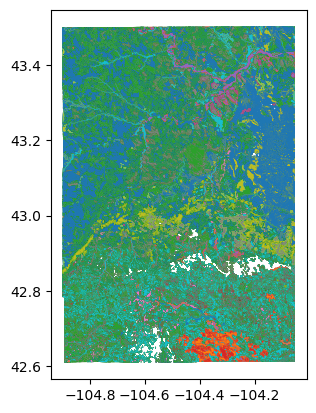

In [61]:
gdf_shp.plot('texcl')